In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0610/weights_KD_segformer_0610_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.5
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0138

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - loss: 0.0090
Average validation loss: 0.674383282661438
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 523ms/step - loss: 0.0090 - val_loss: 0.6744
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 499ms/step - loss: 0.0056 - val_loss: 0.6744
Average validation loss: 0.5567330121994019
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 511ms/step - loss: 0.0056 - val_loss: 0.6156
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 495ms/step - loss: 0.0040 - val_loss: 0.6156
Average validation loss: 0.44675612449645996
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 504ms/step - loss: 0.0040 - val_loss: 0.5593
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segfo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 493ms/step - loss: 5.9269e-07
Average validation loss: 0.060493022203445435
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 503ms/step - loss: 5.9269e-07 - val_loss: 0.0605
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 491ms/step - loss: 5.8198e-07 - val_loss: 0.0605
Average validation loss: 0.05838916450738907
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 500ms/step - loss: 5.8198e-07 - val_loss: 0.0594
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 495ms/step - loss: 5.7553e-07 - val_loss: 0.0594
Average validation loss: 0.08954627998173237
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 505ms/step - loss: 5.7553e-07 - val_loss: 0.0695
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 491ms/step - loss: 5.7014e-07 - val_loss: 0

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 493ms/step - loss: 2.8566e-07
Average validation loss: 0.06865439377725124
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 502ms/step - loss: 2.8566e-07 - val_loss: 0.0687
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 493ms/step - loss: 2.8934e-07 - val_loss: 0.0687
Average validation loss: 0.07598496104280154
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 500ms/step - loss: 2.8934e-07 - val_loss: 0.0723
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 494ms/step - loss: 2.8402e-07 - val_loss: 0.0723
Average validation loss: 0.06301309292515118
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 503ms/step - loss: 2.8402e-07 - val_loss: 0.0692
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_15.pth'.
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 491ms/step - loss: 2.8704e-0

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 493ms/step - loss: 1.5563e-07
Average validation loss: 0.07610686868429184
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 501ms/step - loss: 1.5563e-07 - val_loss: 0.0761
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 490ms/step - loss: 1.5746e-07 - val_loss: 0.0761
Average validation loss: 0.08648339938372374
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 498ms/step - loss: 1.5746e-07 - val_loss: 0.0813
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 491ms/step - loss: 1.4871e-07 - val_loss: 0.0813
Average validation loss: 0.17312056198716164
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 500ms/step - loss: 1.4871e-07 - val_loss: 0.1119
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 491ms/step - loss: 1.4318e-07 - val_loss: 0.1119
Average validation loss: 0.12147046625614166
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 500ms/step - loss: 1.4318e-07 - val_loss: 0.1143
Epoch 5/10


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 495ms/step - loss: 1.7521e-07
Average validation loss: 0.06615807674825191
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 502ms/step - loss: 1.7521e-07 - val_loss: 0.0662
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 493ms/step - loss: 1.5522e-07 - val_loss: 0.0662
Average validation loss: 0.023677146155387165
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 502ms/step - loss: 1.5522e-07 - val_loss: 0.0449
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 496ms/step - loss: 1.4049e-07 - val_loss: 0.0449
Average validation loss: 0.053690052963793276
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 503ms/step - loss: 1.4049e-07 - val_loss: 0.0478
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 495ms/step - loss: 1.349

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 494ms/step - loss: 2.0709e-07
Average validation loss: 0.021212798232833546
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 502ms/step - loss: 2.0709e-07 - val_loss: 0.0212
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 493ms/step - loss: 1.7648e-07 - val_loss: 0.0212
Average validation loss: 0.0316160194731007
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 500ms/step - loss: 1.7648e-07 - val_loss: 0.0264
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 493ms/step - loss: 1.5713e-07 - val_loss: 0.0264
Average validation loss: 0.0345202285485963
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 501ms/step - loss: 1.5713e-07 - val_loss: 0.0291
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 495ms/step - loss: 1.4068e-07 - val_loss: 0.0291
Average validation loss: 0.016235239105299115
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 503ms/step - loss: 1.4068e-07 - val_loss: 0.0259
Saved mod

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 494ms/step - loss: 1.6865e-07
Average validation loss: 0.041149212745949626
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 502ms/step - loss: 1.6865e-07 - val_loss: 0.0411
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 494ms/step - loss: 1.5589e-07 - val_loss: 0.0411
Average validation loss: 0.04706649011932314
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 502ms/step - loss: 1.5589e-07 - val_loss: 0.0441
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 60s 494ms/step - loss: 1.4638e-07 - val_loss: 0.0441
Average validation loss: 0.05914952950552106
40/40 ━━━━━━━━━━━━━━━━━━━━ 60s 502ms/step - loss: 1.4638e-07 - val_loss: 0.0491
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 80s 490ms/step - loss: 1.3832e-07 - val_loss: 0.0491
Average validation loss: 0.052134133456274864
40/40 ━━━━━━━━━━━━━━━━━━━━ 80s 498ms/step - loss: 1.3832e-07 - val_loss: 0.0499
Epoch 5

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 494ms/step - loss: 1.1765e-07
Average validation loss: 0.02540120924822986
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 501ms/step - loss: 1.1765e-07 - val_loss: 0.0254
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 48s 490ms/step - loss: 1.0846e-07 - val_loss: 0.0254
Average validation loss: 0.023895668409143884
48/48 ━━━━━━━━━━━━━━━━━━━━ 48s 498ms/step - loss: 1.0846e-07 - val_loss: 0.0246
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 72s 494ms/step - loss: 1.0443e-07 - val_loss: 0.0246
Average validation loss: 0.020173315114031237
48/48 ━━━━━━━━━━━━━━━━━━━━ 72s 502ms/step - loss: 1.0443e-07 - val_loss: 0.0232
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\w

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 492ms/step - loss: 1.2327e-07
Average validation loss: 0.022855363320559263
56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 499ms/step - loss: 1.2327e-07 - val_loss: 0.0229
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 492ms/step - loss: 1.0680e-07 - val_loss: 0.0229
Average validation loss: 0.020264597576377646
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 499ms/step - loss: 1.0680e-07 - val_loss: 0.0216
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 84s 493ms/step - loss: 9.7556e-08 - val_loss: 0.0216
Average validation loss: 0.018663548631593585
56/56 ━━━━━━━━━━━━━━━━━━━━ 84s 501ms/step - loss: 9.7556e-08 - val_loss: 0.0206
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 494ms/step - loss: 8.1582e-08
Average validation loss: 0.018706621194723994
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 502ms/step - loss: 8.1582e-08 - val_loss: 0.0187
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 64s 493ms/step - loss: 6.8223e-08 - val_loss: 0.0187
Average validation loss: 0.02092983276816085
64/64 ━━━━━━━━━━━━━━━━━━━━ 64s 501ms/step - loss: 6.8223e-08 - val_loss: 0.0198
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 96s 492ms/step - loss: 6.2033e-08 - val_loss: 0.0198
Average validation loss: 0.019144418300129473
64/64 ━━━━━━━━━━━━━━━━━━━━ 96s 499ms/step - loss: 6.2033e-08 - val_loss: 0.0196
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 128s 495ms/step - loss: 5.7265e-08 - val_loss: 0.0196
Average validation loss: 0.01814030046807602
64/64 ━━━━━━━━━━━━━━━━━━━━ 128s 502ms/step - loss: 5.7265e-08 - val_loss: 0.0192
Saved

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 492ms/step - loss: 5.4074e-08
Average validation loss: 0.025800900326834783
72/72 ━━━━━━━━━━━━━━━━━━━━ 36s 499ms/step - loss: 5.4074e-08 - val_loss: 0.0258
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 72s 494ms/step - loss: 5.1199e-08 - val_loss: 0.0258
Average validation loss: 0.026659383283307154
72/72 ━━━━━━━━━━━━━━━━━━━━ 72s 502ms/step - loss: 5.1199e-08 - val_loss: 0.0262
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 108s 494ms/step - loss: 5.1685e-08 - val_loss: 0.0262
Average validation loss: 0.0219981647355275
72/72 ━━━━━━━━━━━━━━━━━━━━ 108s 502ms/step - loss: 5.1685e-08 - val_loss: 0.0248
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_90.pth'.
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 144s 494ms/step - loss: 4.9

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 489ms/step - loss: 5.9199e-08
Average validation loss: 0.024202168034389616
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 497ms/step - loss: 5.9199e-08 - val_loss: 0.0242
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 79s 494ms/step - loss: 5.3360e-08 - val_loss: 0.0242
Average validation loss: 0.02533980868756771
80/80 ━━━━━━━━━━━━━━━━━━━━ 80s 502ms/step - loss: 5.3360e-08 - val_loss: 0.0248
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 119s 493ms/step - loss: 5.0039e-08 - val_loss: 0.0248
Average validation loss: 0.02340805933345109
80/80 ━━━━━━━━━━━━━━━━━━━━ 120s 501ms/step - loss: 5.0039e-08 - val_loss: 0.0243
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_100.pth'.
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 159s 491ms/step - loss: 4

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 494ms/step - loss: 2.2356e-07
Average validation loss: 0.032255824228438236
96/96 ━━━━━━━━━━━━━━━━━━━━ 48s 501ms/step - loss: 2.2356e-07 - val_loss: 0.0323
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 95s 493ms/step - loss: 1.5947e-07 - val_loss: 0.0323
Average validation loss: 0.02332097468509649
96/96 ━━━━━━━━━━━━━━━━━━━━ 96s 500ms/step - loss: 1.5947e-07 - val_loss: 0.0278
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 144s 495ms/step - loss: 1.4450e-07 - val_loss: 0.0278
Average validation loss: 0.02807298426826795
96/96 ━━━━━━━━━━━━━━━━━━━━ 144s 502ms/step - loss: 1.4450e-07 - val_loss: 0.0279
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 192s 492ms/step - loss: 1

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 59s 491ms/step - loss: 4.0421e-07
Average validation loss: 0.04303222137192885
120/120 ━━━━━━━━━━━━━━━━━━━━ 60s 499ms/step - loss: 4.0421e-07 - val_loss: 0.0430
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 119s 492ms/step - loss: 2.6439e-07 - val_loss: 0.0430
Average validation loss: 0.025409659929573537
120/120 ━━━━━━━━━━━━━━━━━━━━ 120s 500ms/step - loss: 2.6439e-07 - val_loss: 0.0342
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 179s 492ms/step - loss: 2.0873e-07 - val_loss: 0.0342
Average validation loss: 0.021974841055149835
120/120 ━━━━━━━━━━━━━━━━━━━━ 180s 499ms/step - loss: 2.0873e-07 - val_loss: 0.0301
Saved model weights to 'c:\天_11157065\git\Ripple

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 71s 492ms/step - loss: 1.5726e-07
Average validation loss: 0.019670756070505984
144/144 ━━━━━━━━━━━━━━━━━━━━ 72s 500ms/step - loss: 1.5726e-07 - val_loss: 0.0197
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 143s 493ms/step - loss: 1.3282e-07 - val_loss: 0.0197
Average validation loss: 0.016938994497953292
144/144 ━━━━━━━━━━━━━━━━━━━━ 144s 500ms/step - loss: 1.3282e-07 - val_loss: 0.0183
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 215s 492ms/step - loss: 1.1540e-07 - val_loss: 0.0183
Average validation loss: 0.01863312063263341
144/144 ━━━━━━━━━━━━━━━━━━━━ 216s 499ms/step - loss: 1.1540e-07 - val_loss: 0.0184
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 287s 493

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 79s 492ms/step - loss: 5.7676e-08
Average validation loss: 0.015725772066070932
160/160 ━━━━━━━━━━━━━━━━━━━━ 80s 499ms/step - loss: 5.7676e-08 - val_loss: 0.0157
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 159s 492ms/step - loss: 4.9553e-08 - val_loss: 0.0157
Average validation loss: 0.017005805492590297
160/160 ━━━━━━━━━━━━━━━━━━━━ 160s 500ms/step - loss: 4.9553e-08 - val_loss: 0.0164
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 238s 491ms/step - loss: 4.4785e-08 - val_loss: 0.0164
Average validation loss: 0.019235225940064993
160/160 ━━━━━━━━━━━━━━━━━━━━ 239s 498ms/step - loss: 4.4785e-08 - val_loss: 0.0173
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 318s 491ms/step - loss: 4.2196e-08 - val_loss: 0.0173
Average validation loss: 0.014496710871753749
160/160 ━━━━━━━━━━━━━━━━━━━━ 319s 499ms/step - loss: 4.2196e-08 -

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 99s 495ms/step - loss: 6.5388e-08
Average validation loss: 0.01729849541792646
200/200 ━━━━━━━━━━━━━━━━━━━━ 100s 502ms/step - loss: 6.5388e-08 - val_loss: 0.0173
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 200s 496ms/step - loss: 5.7300e-08 - val_loss: 0.0173
Average validation loss: 0.018077603415440534
200/200 ━━━━━━━━━━━━━━━━━━━━ 201s 503ms/step - loss: 5.7300e-08 - val_loss: 0.0177
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 300s 495ms/step - loss: 5.1208e-08 - val_loss: 0.0177
Average validation loss: 0.020596465713169892
200/200 ━━━━━━━━━━━━━━━━━━━━ 302s 503ms/step - loss: 5.1208e-08 - val_loss: 0.0187
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 401s 496ms/step - loss: 7.2586e-08 - val_loss: 0.0187
Average validation loss: 0.018861313982924913
200/200 ━━━━━━━━━━━━━━━━━━━━ 402s 503ms/step - loss: 7.2586e-08 -

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 119s 496ms/step - loss: 6.8214e-08
Average validation loss: 0.025653245095842672
240/240 ━━━━━━━━━━━━━━━━━━━━ 121s 503ms/step - loss: 6.8214e-08 - val_loss: 0.0257
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 240s 495ms/step - loss: 5.6697e-08 - val_loss: 0.0257
Average validation loss: 0.01850909736980005
240/240 ━━━━━━━━━━━━━━━━━━━━ 241s 503ms/step - loss: 5.6697e-08 - val_loss: 0.0221
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 361s 496ms/step - loss: 5.0648e-08 - val_loss: 0.0221
Average validation loss: 0.01884355775922207
240/240 ━━━━━━━━━━━━━━━━━━━━ 362s 503ms/step - loss: 5.0648e-08 - val_loss: 0.0210
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 481s 49

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.15507760629057885, 0.07976245536468923, 0.06567993476986884, 0.06961103147361428, 0.046563837866298856, 0.037491743521144, 0.03790347430855035, 0.02652852247857178, 0.022966585866441687, 0.021919341659522616, 0.022295569709967825, 0.022346778655890378, 0.025730212516694637, 0.022799273001020387, 0.021878923451642746, 0.018641219311725764, 0.019340072460362717, 0.019205503264767075]
std_val_losses =  [0.1343639751976878, 0.04025616555737424, 0.03454317196721721, 0.031217961168262986, 0.022015044631966692, 0.014854355507707686, 0.015369888766926347, 0.0044828788573599045, 0.003728707833912882, 0.002935635200016913, 0.0045015457765297685, 0.0036651517837807627, 0.005932661711695012, 0.004405237450982904, 0.0028536538112661084, 0.003644168038937342, 0.0031156899643504216, 0.002944439019241444]


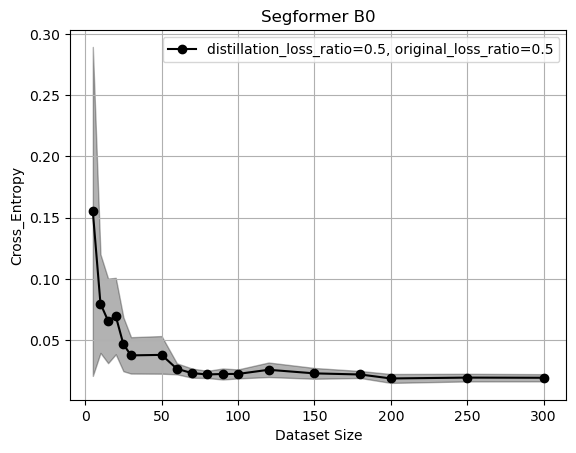

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0610')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.png"))

plt.show()